# Programming Assignment: Image Processing


Для начала нужно запустить готовую модель vgg16, предобученную на imagenet. Модель обучена с помощью caffe и сконвертирована в формат tensorflow - vgg16_weights.npz. Скрипт, иллюстрирующий применение этой модели к изображению, находится внутри ноутбука vgg16.ipynb и возвращает топ-5 классов из imagenet, а так же уверенность в этих классах.  


In [1]:
import glob
import os
import tensorflow as tf
import numpy as np
import scipy

from imagenet_classes import class_names
import sys
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageTk, Image
from imageio import imread

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class vgg16:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print(i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))


In [4]:
# Функция сохранения в файл ответа, состоящего из одного числа
def save_answerNum(fname,number):
    with open(fname,"w") as fout:
        fout.write(str(number))

In [5]:
# Функция сохранения в файл ответа, представленного массивом
def save_answerArray(fname,array):
    with open(fname,"w") as fout:
        fout.write(" ".join([str(el) for el in array]))

In [6]:
# Загрузка словаря из текстового файла. Словарь у нас используется для сохранения меток классов в выборке data.
def load_txt(fname):
    line_dict = {}
    for line in open(fname):
        fname, class_id = line.strip().split()
        line_dict[fname] = class_id

    return line_dict

Инициируем TF сессию, и инициализируем модель. На этом шаге модель загружает веса. Веса - это 500Мб в сжатом виде и ~2.5Гб в памяти, процесс их загрузки послойно выводится ниже этой ячейки, и если вы увидите этот вывод ещё раз - 
у вас неистово кончается память. Остановитесь. Также, не запускайте эту ячейку на выполнение больше одного раза за запуск ядра Jupyter.

In [7]:
# Функция обработки отдельного изображения, печатает метки TOP-5 классов и уверенность модели в каждом из них.
def process_image(fname):
    #img1 = imread(fname, pilmode='RGB')
    #img1 = imresize(img1, (224, 224))
    
    prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
    preds = (np.argsort(prob)[::-1])[0:5]
    for p in preds:
        print(class_names[p], prob[p])

In [8]:
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16(imgs, 'vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


## Task №1
Загрузите уверенность первого класса для изображения train/00002.jpg с точностью до 1го знака после запятой.

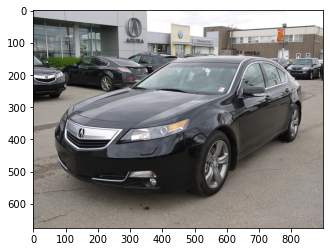

In [9]:
path = 'train/00002.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)

In [10]:
path = 'train/00002_224x224.npy'
img1 = np.load(path, allow_pickle=True, encoding='bytes')

In [11]:
process_image(img1)

minivan 0.4000315
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon 0.11736081
sports car, sport car 0.050051864
car wheel 0.045313906
grille, radiator grille 0.032082397


## Task №2

Научитесь извлекать fc2 слой. Для этого нужно модифицировать process_image, чтобы вместо последнего слоя извлекались выходы fc2.

Посчитайте fc2 для картинки train/00002.jpg. Запишите первые 20 компонент (каждое число с новой строки, т.е. в загружаемом файле должно получиться 20 строк).


In [12]:
def process_image_f2(fname):
    img1 = imread(fname, pilmode='RGB')
    img1 = imresize(img1, (224, 224))
    
    prob = sess.run(vgg.fc2, feed_dict={vgg.imgs: [img1]})[0]
    print(prob[:20])

## Task №3

Теперь необходимо дообучить классификатор на нашей базе. В качестве бейзлайна предлагается воспользоваться классификатором svm из пакета sklearn.

Модифицировать функцию get_features и добавить возможность вычислять fc2. (Мы это уже сделали в process_image).
Применить get_features, чтобы получить X_test и Y_test.
Воспользоваться классификатором, SVC с random_state=0.


In [13]:
# Обработка уже подготовленных массивов X, Y. 
def process_prepared():
    X = np.load('X.npy', allow_pickle=True, encoding='bytes')
    Y = np.load('Y.npy', allow_pickle=True, encoding='bytes')
    X_test = np.load('X_test.npy', allow_pickle=True, encoding='bytes')
    Y_test = np.load('Y_test.npy', allow_pickle=True, encoding='bytes')

    # Ваш код здесь. 
    np.random.seed(0)
    clf = SVC()
    clf.fit(X, Y) 
    
    Y_test_pred = clf.predict(X_test)
    print(sum(Y_test == Y_test_pred)) # Число правильно предсказанных классов

In [14]:
process_prepared()

88
